# Split-Sample Validation

## What Is Split-Sample Validation?

Split-sample validation (also called the hold-out method) tackles overfitting head-on by reserving part of the data for evaluation. The test set is not used in model training, and thus evaluation on the test set shall properly reflect the tendency of overfitting when applied to a new dataset. 

---

### How It Works

1. **Random** Split
   Divide the dataset once into two portions:

   * **Training set** $q\%$ (e.g., $70 – 90 \%$)
   * **Test set** – the remaining $(1-q)\%$

   Randomization ensures that both sets are drawn from the same data-generating mechanism.

   **Warning**:** If the data have structure (time series, spatial correlations, grouped labs, etc.), use a *structured* split so that data leakage doesn't occur.

2. Model Training
   Explore and train **any** models you would like to on the training set

3. Model Evaluation
   Evaluate each trained model on the **test set** once (e.g., estimate the RMSE of the predicted results on the test set)
   

4. **Final Fit**
   Pick the model with the best performance (e.g., lowest RMSE or highest accuracy).
   Refit the chosen model on the **entire dataset** before deployment.

--- 

### Why It Works?

The training never involes the test data, so performance evaluated on the test set mimics performance on truly new data.

---

### Pros and Cons

✅ Straightforward concept & implementation.   
✅ Fast 

❌ Wastes data for training  
❌ Performance estimate can be noisy with a small test set                                        





Check out this (very interesting) illustration from [MLU](https://mlu-explain.github.io/train-test-validation/).

In [1]:
import numpy as np, matplotlib.pyplot as plt, seaborn as sns
from ipywidgets import Button, Output, VBox
from IPython.display import display
from matplotlib.patches import Rectangle


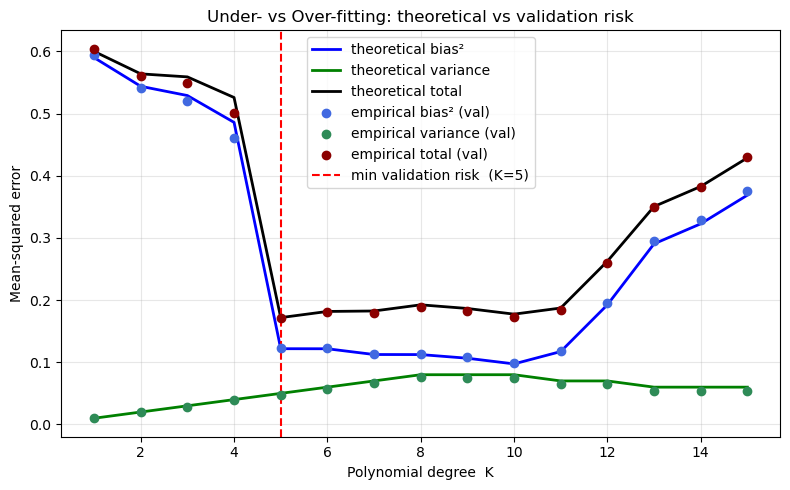

In [2]:

# 1 · true function and deterministic training grid -----------------
n_train = 100
x_train = np.linspace(0, 4, n_train)
f_true  = np.sin(np.pi * x_train) + 0.5*np.sin(2*np.pi * x_train)
sigma2  = 1.0                    # noise variance

def poly_design(x, K):
    return np.column_stack([x**k for k in range(1, K+1)])

# 2 · theoretical bias² & variance on the *training* grid -----------
def theo_components(K):
    X = poly_design(x_train, K)
    H = X @ np.linalg.pinv(X.T @ X) @ X.T
    bias2 = np.mean(((np.eye(n_train) - H) @ f_true) ** 2)
    var   = sigma2 * np.trace(H @ H.T) / n_train
    return bias2, var, bias2 + var

Kmax = 15
Ks   = np.arange(1, Kmax+1)
bias_t, var_t, tot_t = zip(*(theo_components(k) for k in Ks))

# 3 · Monte-Carlo validation risk on *independent* 20-point set -----
n_val   = 20
n_sims  = 2_000
rng     = np.random.default_rng(0)

# storage for empirical curves
val_risk   = np.zeros((Kmax,))
val_bias2  = np.zeros((Kmax,))
val_var    = np.zeros((Kmax,))

# fix validation x once; draw fresh noise every sim
x_val = np.linspace(0.1, 3.9, n_val)           # evenly-spaced validation grid
f_val = np.sin(np.pi * x_val) + 0.5*np.sin(2*np.pi * x_val)

for K in Ks:
    preds = np.zeros((n_sims, n_val))
    Xtr   = poly_design(x_train, K)
    Xv    = poly_design(x_val,   K)
    P     = Xv @ np.linalg.pinv(Xtr.T @ Xtr) @ Xtr.T  # maps train y → val preds

    # Monte-Carlo loop (vectorised)
    eps   = rng.normal(size=(n_sims, n_train))
    y_tr  = f_true + eps
    preds = y_tr @ P.T           # (2k sims × n_val)
    # empirical quantities
    val_risk[K-1]  = np.mean((preds - f_val)**2)
    val_bias2[K-1] = np.mean((preds.mean(axis=0) - f_val)**2)
    val_var[K-1]   = np.mean(preds.var(axis=0))

# 4 · plot ----------------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(Ks, bias_t, label="theoretical bias²",   color="blue", lw=2)
plt.plot(Ks, var_t,  label="theoretical variance",color="green",lw=2)
plt.plot(Ks, tot_t,  label="theoretical total",   color="black",lw=2)

plt.scatter(Ks, val_bias2, marker="o", color="royalblue",
            label="empirical bias² (val)", zorder=3)
plt.scatter(Ks, val_var,   marker="o", color="seagreen",
            label="empirical variance (val)", zorder=3)
plt.scatter(Ks, val_risk,  marker="o", color="darkred",
            label="empirical total (val)", zorder=3)

best_k = Ks[np.argmin(val_risk)]
plt.axvline(best_k, ls="--", color="red",
            label=f"min validation risk  (K={best_k})")

plt.xlabel("Polynomial degree  K")
plt.ylabel("Mean-squared error")
plt.title("Under- vs Over-fitting: theoretical vs validation risk")
plt.legend(); plt.grid(alpha=.3); plt.tight_layout()
plt.show()
